# Simulated DCA Demo

In [ ]:
from hyppo.tools import SIMULATIONS
import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA

import dist_cov as dc

In [ ]:
np.random.seed(0)

# 1D Random Data
## Initialize Data

In [ ]:
X = np.random.rand(20, 1) # NxM, test with Nx1 vector of N samples
Y = np.random.rand(15, 1)
N = 10
D_X = dc.dist_mat(X, N)
D_Y = dc.dist_mat(Y, N)
R_X = dc.re_centered_dist(D_X)
R_Y = dc.re_centered_dist(D_Y)
u = np.random.rand(X.shape[1], 1)
u = dc.clamp_u(u)
u_norm = LA.norm(u)
print(f"u: {u}")
print(f"u norm: {u_norm}")
R_X_u = dc.re_centered_dist_u(u, X, N)

u: [[0.6176355]]
u norm: 0.6176354970758771


## Test Function Dimension Alignment

In [ ]:
du = dc.dist_cov_sq_grad(u, X, Y, R_X, R_Y)
print(f"dvdu: {du}")
v = dc.dist_cov_sq(R_X, R_Y)
print(f"v^2: {v}")

dvdu: [[0.01150668]]
v^2: 0.011506680827201661


## Optimize $u$

In [ ]:
v_u = dc.dist_cov_sq(R_Y, R_X_u)
print(f"v^2_u: {v_u}")
u_opt = dc.optim_u_gd(u, X, Y, R_X, R_Y, .1, 1000)
print(f"u opt: {u_opt}")
R_X_u_opt = dc.re_centered_dist_u(u_opt, X, N)
v_u_opt = dc.dist_cov_sq(R_Y, R_X_u_opt)
print(f"v^2_u_opt: {v_u_opt}")

v^2_u: 0.007106934532402166
u opt: [[1.]]
v^2_u_opt: 0.011506680827201661


## Plot Gradient Ascent

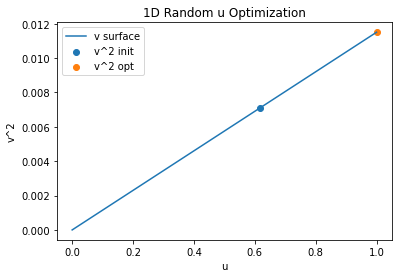

In [ ]:
u_plt = np.expand_dims(np.linspace(0, 1, 11), 1)
v_u_plt = []
for i in range(u_plt.shape[0]):
    R_X_u_i = dc.re_centered_dist_u(u_plt[i], X, N)
    v_u_i = dc.dist_cov_sq(R_Y, R_X_u_i)
    v_u_plt.append(v_u_i)
plt.plot(u_plt, v_u_plt)
plt.scatter([u], [v_u])
plt.scatter([u_opt], [v_u_opt])
plt.xlabel("u")
plt.ylabel("v^2")
plt.title("1D Random u Optimization")
plt.legend(['v surface', 'v^2 init', 'v^2 opt']);

# 1D Simulated Linear Independence Data
## Plot Dataset

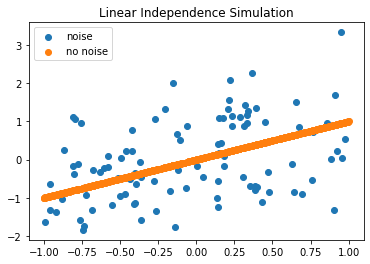

In [ ]:
lin_sim = SIMULATIONS["linear"]
lin_x_n, lin_y_n = lin_sim(100, 1, noise=True)
lin_x, lin_y = lin_sim(1000, 1)
plt.scatter(lin_x_n, lin_y_n)
plt.scatter(lin_x, lin_y)
plt.title("Linear Independence Simulation")
plt.legend(["noise", "no noise"]);

## Initialize Data

In [ ]:
X, Y = lin_sim(100, 1, noise=True)
N = 10
D_X = dc.dist_mat(X, N)
D_Y = dc.dist_mat(Y, N)
R_X = dc.re_centered_dist(D_X)
R_Y = dc.re_centered_dist(D_Y)
u = np.random.rand(X.shape[1], 1)
u = dc.clamp_u(u)
u_norm = LA.norm(u)
print(f"u: {u}")
print(f"u norm: {u_norm}")
R_X_u = dc.re_centered_dist_u(u, X, N)

u: [[0.60303814]]
u norm: 0.603038139426371


## Test Function Dimension Alignment

In [ ]:
du = dc.dist_cov_sq_grad(u, X, Y, R_X, R_Y)
print(f"dvdu: {du}")
v = dc.dist_cov_sq(R_X, R_Y)
print(f"v^2: {v}")

dvdu: [[0.19729928]]
v^2: 0.197299280552371


## Optimize $u$

In [ ]:
v_u = dc.dist_cov_sq(R_Y, R_X_u)
print(f"v^2_u: {v_u}")
u_opt = dc.optim_u_gd(u, X, Y, R_X, R_Y, .1, 1000)
print(f"u opt: {u_opt}")
R_X_u_opt = dc.re_centered_dist_u(u_opt, X, N)
v_u_opt = dc.dist_cov_sq(R_Y, R_X_u_opt)
print(f"v^2_u_opt: {v_u_opt}")

v^2_u: 0.11897899105446337
u opt: [[1.]]
v^2_u_opt: 0.197299280552371


## Plot Gradient Ascent

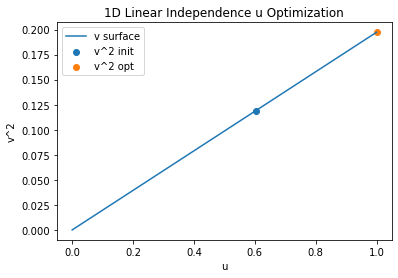

In [ ]:
u_plt = np.expand_dims(np.linspace(0, 1, 11), 1)
v_u_plt = []
for i in range(u_plt.shape[0]):
    R_X_u_i = dc.re_centered_dist_u(u_plt[i], X, N)
    v_u_i = dc.dist_cov_sq(R_Y, R_X_u_i)
    v_u_plt.append(v_u_i)
plt.plot(u_plt, v_u_plt)
plt.scatter([u], [v_u])
plt.scatter([u_opt], [v_u_opt])
plt.xlabel("u")
plt.ylabel("v^2")
plt.title("1D Linear Independence u Optimization")
plt.legend(['v surface', 'v^2 init', 'v^2 opt']);